In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18
from PIL import Image

DATA_ROOT = "../mvtec_anomaly_detection"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [2]:
class MVTecDataset(Dataset):
    def __init__(self, root, product, split="train"):
        self.samples = []
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

        base = os.path.join(root, product, split)

        if split == "train":
            img_dir = os.path.join(base, "good")
            for f in os.listdir(img_dir):
                self.samples.append((os.path.join(img_dir, f), 0))
        else:
            for cls in os.listdir(base):
                label = 0 if cls == "good" else 1
                img_dir = os.path.join(base, cls)
                for f in os.listdir(img_dir):
                    self.samples.append((os.path.join(img_dir, f), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        return self.transform(img), label


In [3]:
class ResNet18FeatureMap(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = resnet18(pretrained=True)
        self.features = nn.Sequential(*list(backbone.children())[:-2])

    def forward(self, x):
        return self.features(x)   # [B, C, H, W]


In [4]:
def extract_patch_features(model, loader):
    model.eval()
    patches = []

    with torch.no_grad():
        for x, _ in loader:
            x = x.to(DEVICE)
            fmap = model(x)          # [B, C, H, W]
            B, C, H, W = fmap.shape
            fmap = fmap.permute(0, 2, 3, 1)  # [B, H, W, C]
            patches.append(fmap.reshape(-1, C).cpu())

    return torch.cat(patches)


In [5]:
# Build patch feature bank from NORMAL images

PRODUCT = "bottle"   # tạm thời làm 1 product để debug
train_ds = MVTecDataset(DATA_ROOT, PRODUCT, "train")
train_loader = DataLoader(train_ds, batch_size=8, shuffle=False)

model = ResNet18FeatureMap().to(DEVICE)

patch_features = extract_patch_features(model, train_loader)

print("Patch feature shape:", patch_features.shape)


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Patch feature shape: torch.Size([13376, 512])


In [6]:
def compute_anomaly_map(model, patch_bank, img_tensor):
    model.eval()
    with torch.no_grad():
        fmap = model(img_tensor.unsqueeze(0).to(DEVICE))
        fmap = fmap.squeeze(0).permute(1, 2, 0)  # [H, W, C]

        H, W, C = fmap.shape
        fmap = fmap.reshape(-1, C)

        dists = torch.cdist(fmap, patch_bank.to(DEVICE))
        scores = dists.min(dim=1).values

        return scores.reshape(H, W).cpu().numpy()


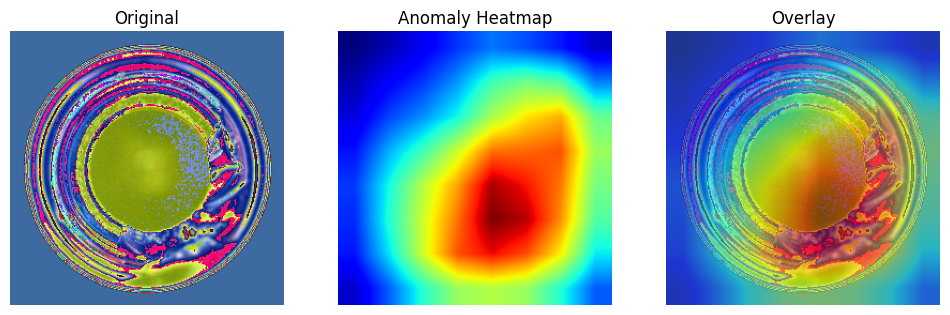

In [7]:
import cv2
from torchvision.transforms.functional import to_pil_image

test_ds = MVTecDataset(DATA_ROOT, PRODUCT, "test")
img_tensor, label = test_ds[0]

anomaly_map = compute_anomaly_map(model, patch_features, img_tensor)

# resize về size ảnh
anomaly_map = cv2.resize(
    anomaly_map,
    (img_tensor.shape[2], img_tensor.shape[1])
)

# normalize
anomaly_map = (anomaly_map - anomaly_map.min()) / (anomaly_map.max() - anomaly_map.min())

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(to_pil_image(img_tensor))
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Anomaly Heatmap")
plt.imshow(anomaly_map, cmap="jet")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Overlay")
plt.imshow(to_pil_image(img_tensor))
plt.imshow(anomaly_map, cmap="jet", alpha=0.5)
plt.axis("off")

plt.show()


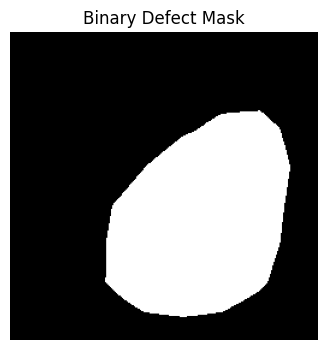

In [8]:
# Threshold anomaly map to binary mask

THRESHOLD = 0.6   # có thể chỉnh sau

binary_mask = (anomaly_map > THRESHOLD).astype(np.uint8)

plt.figure(figsize=(5,4))
plt.title("Binary Defect Mask")
plt.imshow(binary_mask, cmap="gray")
plt.axis("off")
plt.show()


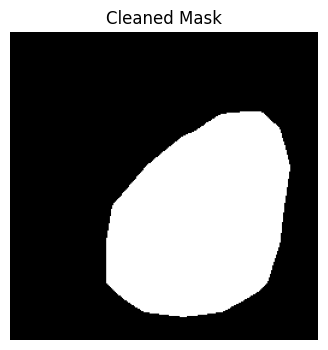

In [9]:
kernel = np.ones((5,5), np.uint8)

clean_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
clean_mask = cv2.morphologyEx(clean_mask, cv2.MORPH_CLOSE, kernel)

plt.figure(figsize=(5,4))
plt.title("Cleaned Mask")
plt.imshow(clean_mask, cmap="gray")
plt.axis("off")
plt.show()


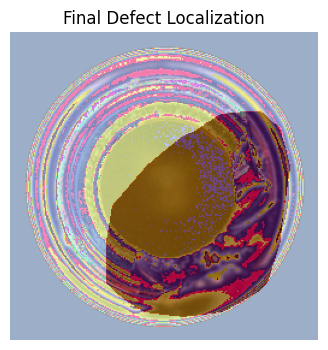

In [10]:
plt.figure(figsize=(5,4))
plt.title("Final Defect Localization")
plt.imshow(to_pil_image(img_tensor))
plt.imshow(clean_mask, cmap="Reds", alpha=0.5)
plt.axis("off")
plt.show()


In [13]:
# Collect pixel-level scores and ground truth masks (FIXED)

pixel_scores = []
pixel_labels = []

test_base = os.path.join(DATA_ROOT, PRODUCT, "test")

for defect_type in os.listdir(test_base):
    if defect_type == "good":
        continue

    img_dir = os.path.join(test_base, defect_type)
    mask_dir = os.path.join(DATA_ROOT, PRODUCT, "ground_truth", defect_type)

    for fname in os.listdir(img_dir):
        img_path = os.path.join(img_dir, fname)
        mask_path = os.path.join(mask_dir, fname.replace(".png", "_mask.png"))

        # load image
        img = Image.open(img_path).convert("RGB")
        img_tensor = test_ds.transform(img)

        anomaly_map = compute_anomaly_map(model, patch_features, img_tensor)
        anomaly_map = cv2.resize(
            anomaly_map,
            (img_tensor.shape[2], img_tensor.shape[1])
        )

        anomaly_map = (anomaly_map - anomaly_map.min()) / (anomaly_map.max() - anomaly_map.min())

        # load & resize GT mask to SAME SIZE
        gt_mask = Image.open(mask_path).convert("L")
        gt_mask = gt_mask.resize(
            (img_tensor.shape[2], img_tensor.shape[1]),
            resample=Image.NEAREST
        )
        gt_mask = np.array(gt_mask) > 0

        pixel_scores.extend(anomaly_map.flatten())
        pixel_labels.extend(gt_mask.flatten())


In [14]:
from sklearn.metrics import roc_curve, roc_auc_score

pixel_scores = np.array(pixel_scores)
pixel_labels = np.array(pixel_labels).astype(np.uint8)

fpr, tpr, thresholds = roc_curve(pixel_labels, pixel_scores)
pixel_auc = roc_auc_score(pixel_labels, pixel_scores)

print(f"Pixel-level AUROC: {pixel_auc:.4f}")


Pixel-level AUROC: 0.9152
